# CE7454 2019 Project -- Group 3

**Add the full name here**

Please find all the models and data at [https://github.com/occia/ce7454-group3-project](https://github.com/occia/ce7454-group3-project)

In [29]:
import sys, os
import time
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import urllib.request as urllib
import scrapy
import json
import re
import matplotlib.pyplot as plt
import cv2 as cv
import argparse
!pip install pandas
import pandas as pd
from IPython.display import Image


from random import randint
from torchvision import transforms

In [6]:
# utility function for a folder creation, if there is no
def create_folder(folder_path):
    directory = os.path.dirname(folder_path)

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

## 1. Project Description

Here briefly introduces the background, and throw out the 2 project questions:
- How accurate the modern neural network models could be? (How to relate this with the Identity Acquisition?)
- What's the performance of age authentication (below/above 18) for current neural networks?

TODO DAVID: Story at the beginning, leading through story during evaluation and conclusion section + Future directions

## 2. Data Preparation

### 2.1 Data Acquisition


For the project, we prepare 2 kinds of data:
- training data
- validation/testing data

#### Bechmark Data

Due to the requirement of the large amount of labeled data, we merged 3 existing labeled benchmark datasets as our training data, including [All-Age-Faces](https://github.com/JingchunCheng/All-Age-Faces-Dataset), [FGNET](https://yanweifu.github.io/FG_NET_data/index.html), [UTK Face](https://susanqq.github.io/UTKFace).

In total, the amount of labelled images from these 3 benchmarks is 38000, 32818 is used for training and 5182 is used for validation/testing.

#### Real-world Data

To validate the performance on the real-world data, we selected Instagram as a source for an additional dataset of unfiltered face images.
We assumed that we may retrieve the age from bio and the actual image from the picture profile.

We processed all the countries one by one as the data required careful validation.
We showcase the data scraping process on a small (100 users) subset of Canadian instagram users.

##### Usernames Scraping 

As we intended to select the users from a particular country, we chose one influencer per country.
We considered the following countries:

European:
* Australia - [@eddiebthe3rd](https://www.instagram.com/eddiebthe3rd/)
* Canada - [@od_officiel](https://www.instagram.com/od_officiel/)
* Germany - [@kontrak](https://www.instagram.com/kontrak/)
* Russia - [@\_agentgirl\_](https://www.instagram.com/_agentgirl_/)

Asian:
* China - [@bingbing_fan](https://www.instagram.com/bingbing_fan/)
* Indonesia - [@jokowi](http://instagram.com/jokowi)
* India - [@narendramodi](http://instagram.com/narendramodi)

Middle Eastern:
* Iran - [@golfarahani](http://instagram.com/golfarahani)

African:
* Ethiopia - [@addisalem_getaneh](https://www.instagram.com/addisalem_getaneh/)
* Nigeria - [@iambisola](https://www.instagram.com/iambisola)

Hispanic:
* Brazil - [@carlinhosmaiaof](https://www.instagram.com/carlinhosmaiaof/)

To identify the necessary influencers we used websites such as [HypeAuditor](https://hypeauditor.com/top-instagram-all-australia/) and [Heepsy](https://www.heepsy.com/ranking/top-instagram-influencers-in-ethiopia) -- we have used it to get the information about the audience, as we were interested in the influencers with the audience which is at least 80% local.

Instagram does not allow scrapping and detects spiders, so we used a third-party application for Instagram called [Imgtagram](https://imgtagram.com/followers/justinbieber). It also allows us to retrieve the usernames in a most efficient way. We also attempted to retrieve usernames by means of visual testing, i.e. Selenium, that imitates user behavior, but it was much slower. 

To do so, we opened a web page of a particular user's followers and scrolled down the page till the number of users shown reaches 125k. We ran the following JS script in a developer's console of a browser:

<pre>
function scrapLinksAndScroll() {
  window.scrollTo(0, document.body.scrollHeight);
}

setInterval(scrapLinksAndScroll, 3); </pre>

The example test file with 100 usernames of Canadian users can be found at <pre> ./data/usernames/canada.txt</pre>.

In [1]:
# defines the data scale, the other option is 'full'
mode = 'test'

# other options for full dataset include 'australia', 'brazil', 'canada', 'china', 'ethiopia', 'germany', 'nigeria'
# 'india', 'indonesia', 'iran', 'russia'
country = 'canada'

##### Biography and Name Scraping
After we collected the usernames, we applied a library called scrapy that allows to scrap the webpage content based on html elements.
    scrapy allows us to do so in a multiprocessing way. The source code of a scraper looks as follows and requires a command 
 
<pre>
    cd scrapy/instascraper/instascraper/
    scrapy crawl profiles -o ../../../data/test/bio/canada.json
</pre>

In this way, we write the collected data of users per country in a json file storing the information regarding their username, name, bio, country, and image URL.

The source code of Scrapy spider implementation can be found at [the following folder](https://github.com/occia/ce7454-group3-project/tree/master/scrapy/instascraper/instascraper).

It also requires the country folder path to be hardcoded, due to an implementation of a spider as a class.

In [ ]:
# The class of a Scrapy spider used to retrieve profiles (name, bio, profile picture URL) of users of a
# particular country.

class QuotesSpider(scrapy.Spider):
    name = 'profiles'
    country = 'canada'
    # Hardcoded path of a country's users names
    file_path = '../../../data/test/usernames/%s.txt' %country
    with open(file_path) as f:
        start_urls = []
        for u in f.readlines():
            start_urls.append('https://imgtagram.com/u/' + u)

    def parse(self, response):
        # Hardcoded name of the country
        country = 'canada'
        for quote in response.css('div.text-block'):
            # The HTML elements we are interested in
            yield {
                'username': quote.css('h3::text').get(),
                'name': quote.css('h1::text').get(),
                'bio': quote.css('p.descp::text').get(),
                'image': response.css('img.icon::attr(src)').get(),
                'country': country
            }

The resulting information is stored in a JSON file that looks like this:

In [30]:
profiles_path = './data/test/bio/%s.json' %country

with open(profiles_path, 'r') as file:
    user_profiles = json.load(file)
    retrieved_profiles = pd.DataFrame.from_dict(user_profiles)

# The Instragram data of the retrieved users
retrieved_profiles

,username,name,bio,image,country
0,@x_.bellita._x,bella❤️,None,https://scontent-cdg2-1.cdninstagram.com/vp/02...,canada
1,@_juliette_girard,Juliette Girard,None,https://scontent-sin2-1.cdninstagram.com/vp/fa...,canada
2,@justine_marcoux10,Justine Marcoux,enjoy the little things🌞\n_13 y/o\n_🎿\n_,https://scontent-cdg2-1.cdninstagram.com/vp/fa...,canada
3,@poutine_myra,Jerami🥰,,https://scontent-cdg2-1.cdninstagram.com/vp/6f...,canada
4,@coraliebillette,Coralie :),Dancer💛\n,https://scontent-cdg2-1.cdninstagram.com/vp/8b...,canada
...,...,...,...,...,...
96,@enyalachance._,,,https://scontent-cdg2-1.cdninstagram.com/vp/07...,canada
97,@rraaphb,,None,https://scontent-cdg2-1.cdninstagram.com/vp/eb...,canada
98,@audreyann.paquet,Audrey-Ann Paquet,27 ans . Rimouski 🌼 ...,https://scontent-cdg2-1.cdninstagram.com/vp/9d...,canada
99,@marie_pierjolin,Marie-Pier Jolin,Une Pinkie heureuse 🌻,https://scontent-cdg2-1.cdninstagram.com/vp/15...,canada


##### Filtering the bio

To identify names and bios that contain age, we have used a regular expression that looks for the numbers in the aforementioned fields that meet the following requirements:

* The previous symbol is not an alphanumeric character or an underscore, except for the case when the previous two symbols are represent a control sequence (\n, \t or \r)
* The number is either in range 1930-1999, or 2000-2019, or 10-99
* The number is not followed by a digit


When collecting our dataset, we also did manual checking to confirm the results.


In [31]:
filtered_profiles = []

input_path = './data/test/bio/%s.json' %country
filtered_folder = './data/test/bio/filtered/'

create_folder(filtered_folder)

output_path = filtered_folder + '%s.json' %country

with open(input_path, 'r') as file:
    user_profiles = json.load(file)
    for user in user_profiles:
        # if the bio is not empty or null
        if user['bio'] and user['bio'] != ' ':
            # check if the bio or name contains a year in range 1930-1999 or 2000-2019
            year_pattern = re.compile("(?:(?<!\w)|(?<=\\[ntr]))(19[3-9]\d|20[01]\d)(?!\d)")
            # check if the bio or name contains a number from 10 to 99
            age_pattern = re.compile("(?:(?<!\w)|(?<=\\[ntr]))([1-9]\d)(?!\d)")
            birth_year_bio = year_pattern.match(user['bio'])
            str_name = str(user['name'])
            birth_year_name = year_pattern.match(str_name)
            age_bio = age_pattern.match(user['bio'])
            age_name = age_pattern.match(str_name)
            # if a bio contains a year
            if birth_year_bio:
                # retrieve and the year found
                year = birth_year_bio.group(1)
                # calculate and record the current age of a user
                age = 2019 - int(year)
                user['age'] = str(age)
                filtered_profiles.append(user)
            # if a name contains a year
            elif birth_year_name:
                # retrieve the year found
                year = birth_year_name.group(1)
                age = 2019 - int(year)
                # calculate and record the current age of a user
                user['age'] = str(age)
                filtered_profiles.append(user)
            # if a bio contains an age
            elif age_bio:
                # retrieve and record the age found
                user['age'] = age_bio.group(1)
                filtered_profiles.append(user)
            elif age_name:
                # if an age contains an age
                user['age'] = age_name.group(1)
                # retrieve and record the age found
                filtered_profiles.append(user)
                
with open(output_path, 'w') as outfile:
    json.dump(filtered_profiles, outfile)
    
age_profiles = pd.DataFrame.from_dict(filtered_profiles)
age_profiles

,username,name,bio,image,country,age
0,@_frederiquem,Frédérique Marceau ♧,"19, St-Félicien, Québec 📍",https://scontent-cdg2-1.cdninstagram.com/vp/a8...,canada,19
1,@maude_montpetit,Maude 🌵,21 | 01.09.17 👼🏼💙 | 🐈🐈🐈🐈🐕🐕 |,https://scontent-cdg2-1.cdninstagram.com/vp/66...,canada,21
2,@daphhh.hamel,Daphh,18/05/19,https://scontent-cdg2-1.cdninstagram.com/vp/8c...,canada,18
3,@mariiepierp21,marie-pier picard,20 ans\n📚Cégep Garneau\n🦷Finissante en hygiène...,https://scontent-cdg2-1.cdninstagram.com/vp/fc...,canada,20
4,@camybr_,CAMILLE,23 | 🔒 | UQAC 🧠,https://scontent-cdg2-1.cdninstagram.com/vp/af...,canada,23
5,@1997kakou,Karel Soucy,22ans 💁‍♀️ ...,https://scontent-cdg2-1.cdninstagram.com/vp/65...,canada,22
6,@annesosimo,𝒜𝓃𝓃𝑒-𝒮𝑜,16yo | ☁️🥥⛓✉️🖇💭\n,https://scontent-cdg2-1.cdninstagram.com/vp/41...,canada,16
7,@alyson_cote,aly ♡,18 || csf\n🥰🌞😙✌,https://scontent-cdg2-1.cdninstagram.com/vp/0a...,canada,18
8,@tiffounne,Tiffany ✴,26 | B.Sc. Kinésiologie | M.Sc. Ergonomie,https://scontent-cdg2-1.cdninstagram.com/vp/47...,canada,26
9,@coralie.sav,Coralie Savard,19/08/02 ❤️ Sc:coralie_sav,https://scontent-cdg2-1.cdninstagram.com/vp/21...,canada,19


##### Scraping the profile pictures

For the collected users having a bio valid with respect to the regex described above, we then downloaded the profile pictures.

In [32]:
# image retrieval
def url_to_image(url):
    resp = urllib.urlopen(url)
    return resp

profiles_path = './data/test/bio/filtered/%s.json' %country
img_path = './data/test/images/%s/' %country

create_folder(img_path)

print('Parsing users of', country)

# profiles JSON parsing
with open(profiles_path, 'r') as file:
    user_profiles = json.load(file)
    for usr in user_profiles[0:]:
        url = usr['image']
        username = usr['username']
        image_path = img_path + username + '.jpg'
    # download the image URL
        if url != '':
            print ("Downloading image")
            image = url_to_image(url)
            f = open(image_path,'wb')
            f.write(image.read())
            f.close()
        

Parsing users of canada


### 2.2 Data Exploration

#### Benchmark Dataset Age Distribution


--2019-11-14 01:01:27--  https://www.dropbox.com/s/q9uc3idcgj1cm8w/ben_distr.png
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.1, 2620:100:6031:1::a27d:5101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/q9uc3idcgj1cm8w/ben_distr.png [following]
--2019-11-14 01:01:27--  https://www.dropbox.com/s/raw/q9uc3idcgj1cm8w/ben_distr.png
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc04675b871201acd0fbdedbf618.dl.dropboxusercontent.com/cd/0/inline/AsSKKjrCavqdp55t2dsNFLdF3NMNWlRS8tvspskmvlvKbLPLClpvUxAco8VD9OIFJ7Js5va-7unnvvDVfSgy5k_ea1FL6wuEuVtWZBjzQhLdmjlvU1-gWXFT3HunErDctF4/file# [following]
--2019-11-14 01:01:28--  https://uc04675b871201acd0fbdedbf618.dl.dropboxusercontent.com/cd/0/inline/AsSKKjrCavqdp55t2dsNFLdF3NMNWlRS8tvspskmvlvKbLPLClpvUxAco8VD9OIFJ7Js5va-7unnvvDVfSgy5k_ea1FL6wuEuVtWZBjzQhLd

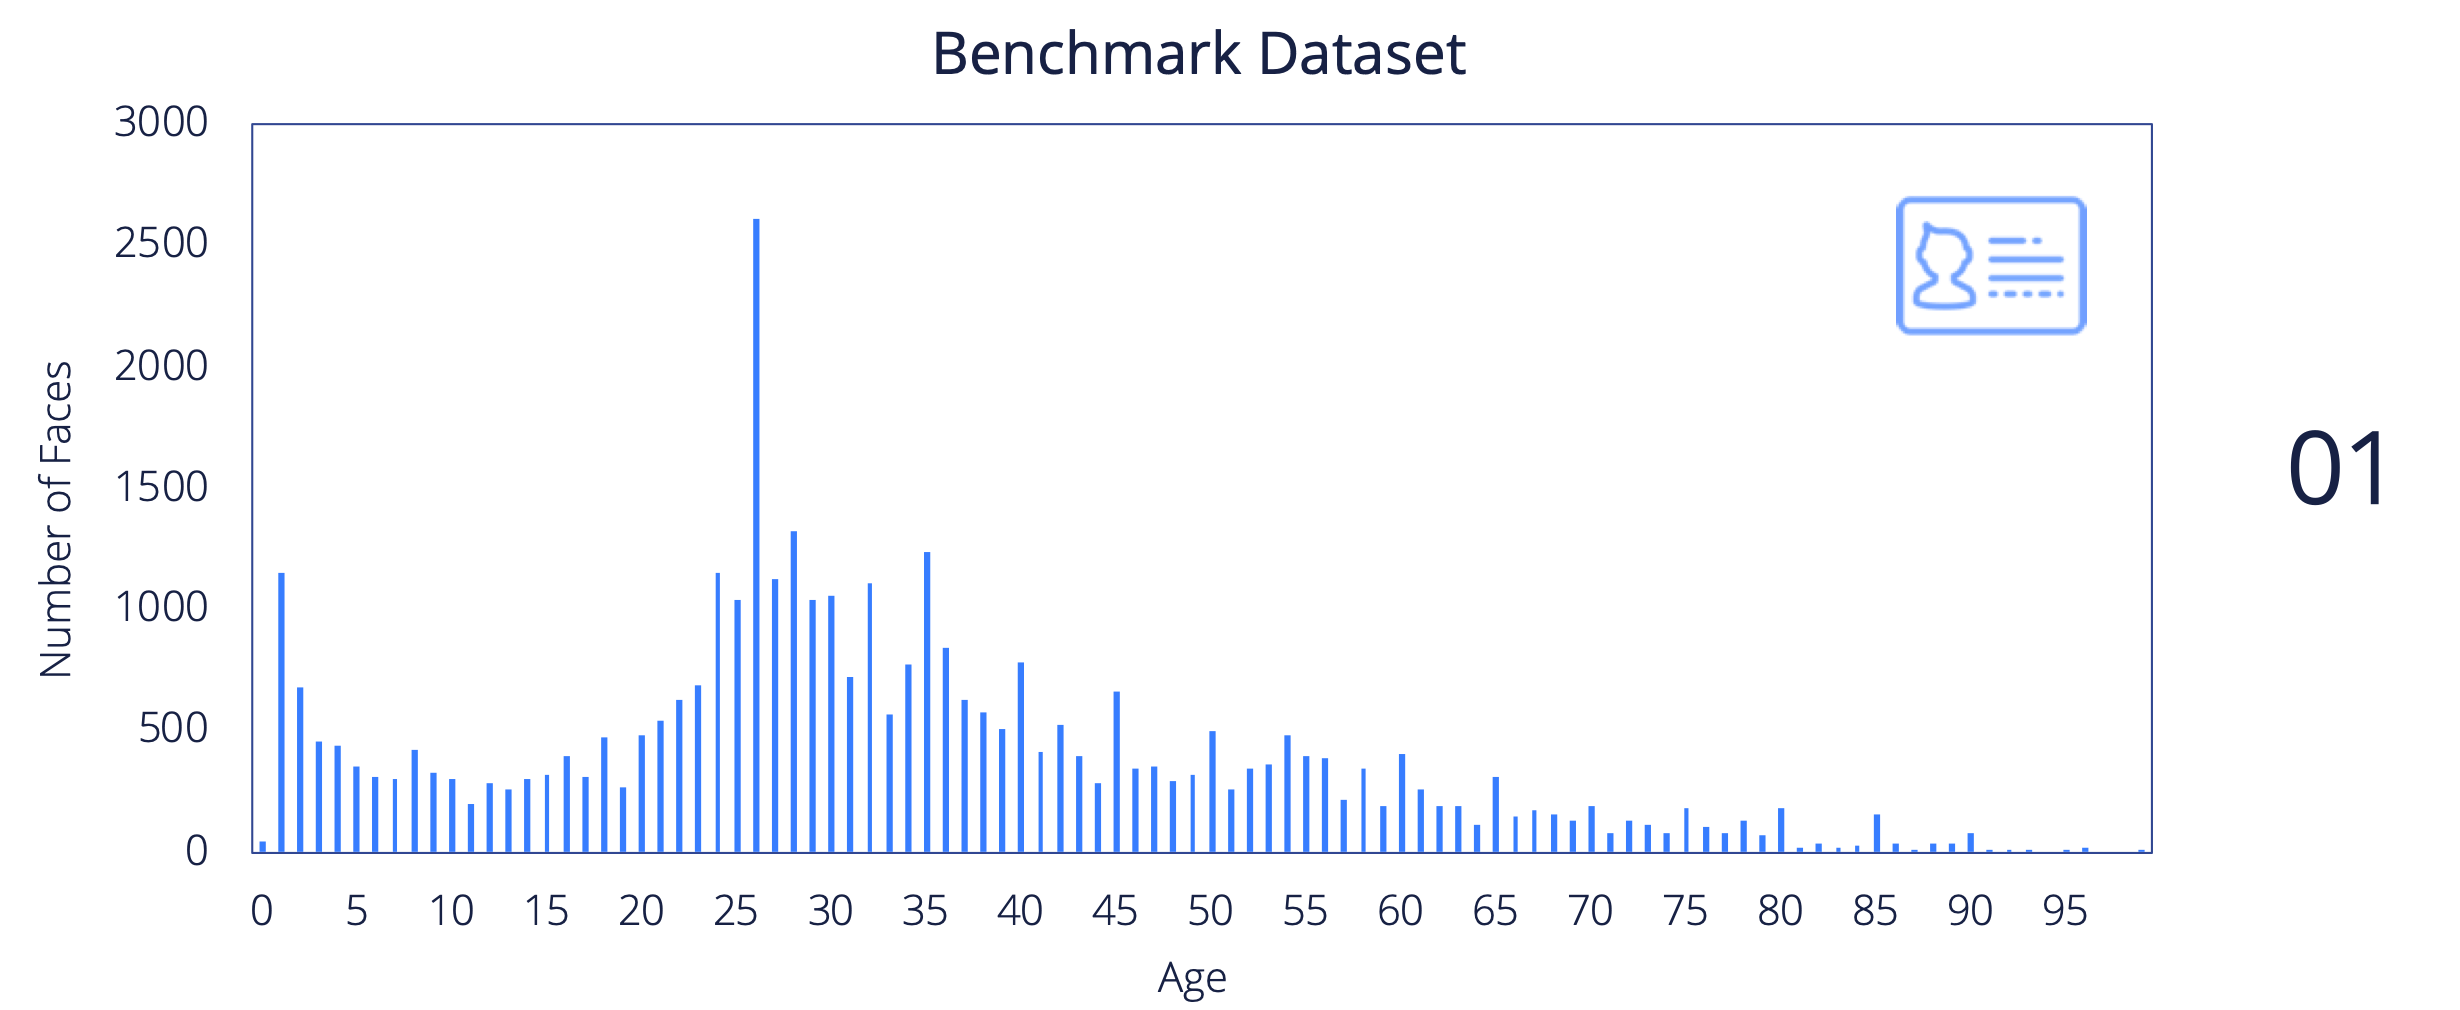

In [41]:
!wget https://www.dropbox.com/s/q9uc3idcgj1cm8w/ben_distr.png
Image('ben_distr.png')

#### Instagram Dataset Age Distribution

--2019-11-14 01:02:07--  https://www.dropbox.com/s/g67166rdrg21929/insta_distr.png
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.1, 2620:100:6031:1::a27d:5101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/g67166rdrg21929/insta_distr.png [following]
--2019-11-14 01:02:07--  https://www.dropbox.com/s/raw/g67166rdrg21929/insta_distr.png
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8faf2be776dc51b5f19208c232.dl.dropboxusercontent.com/cd/0/inline/AsTC-Oq2rIEfynV7Skf0tgHyVzTEVtOTNaNcyukh0t_jBkFkmicDv5K0qz0NKi6A6FVKNSgkktFAVgjkQdIpLT23-4UtKwigJ54L6BVxAMGFm2yhycJaFt6NJflBcCNfrP8/file# [following]
--2019-11-14 01:02:07--  https://uc8faf2be776dc51b5f19208c232.dl.dropboxusercontent.com/cd/0/inline/AsTC-Oq2rIEfynV7Skf0tgHyVzTEVtOTNaNcyukh0t_jBkFkmicDv5K0qz0NKi6A6FVKNSgkktFAVgjkQdIpLT23-4UtKwigJ54L6B

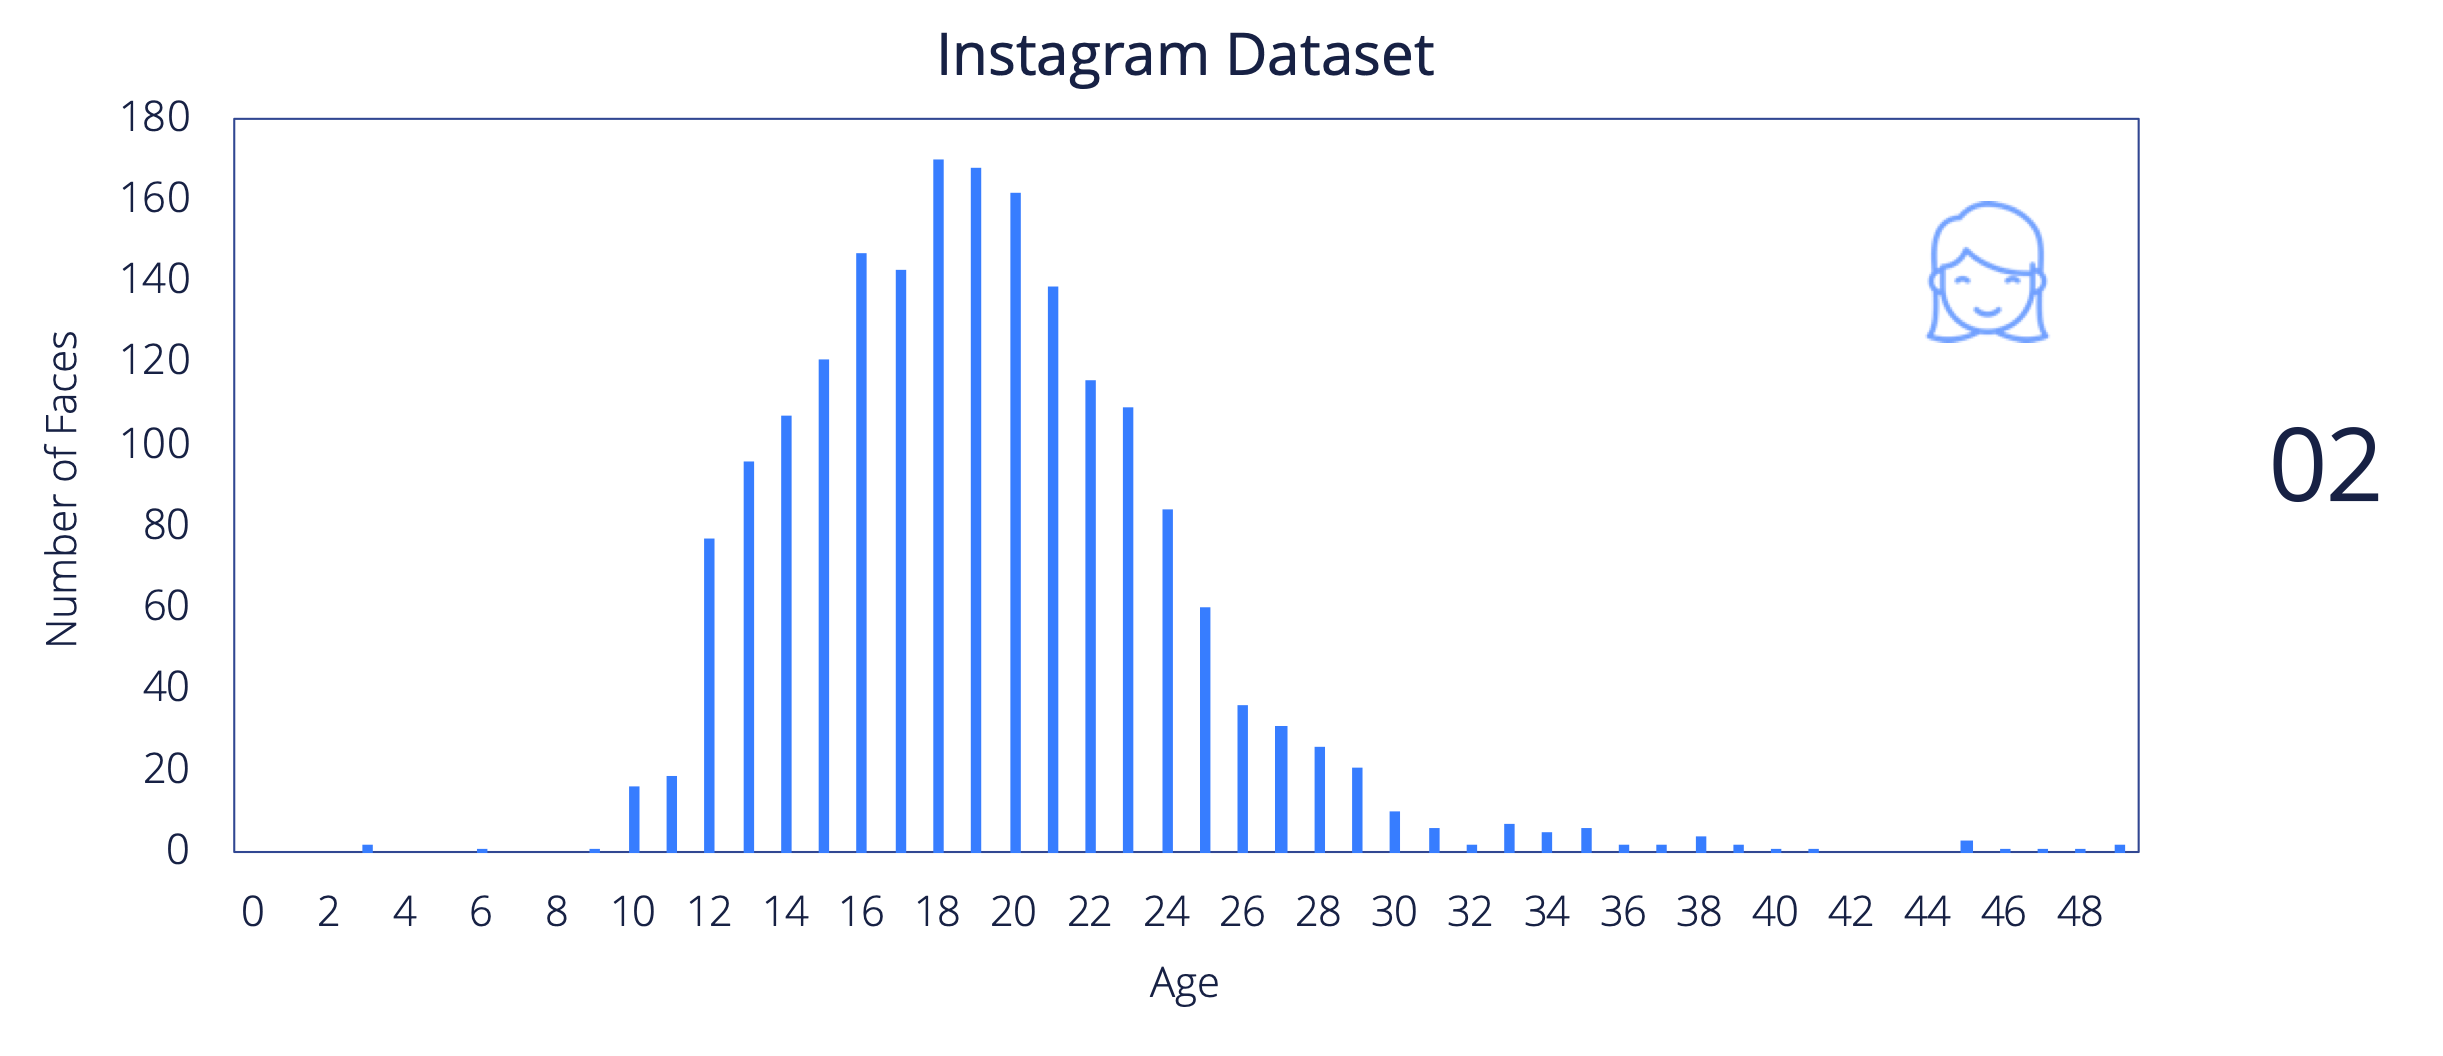

In [43]:
!wget https://www.dropbox.com/s/g67166rdrg21929/insta_distr.png
Image('insta_distr.png')

### 2.3 Data Validation

After exploring the collected profiles data, we have identified the following criteria for a profile to be invalid:
* Bio does not contain age or a year of birth
* A profile picture does not contain faces
* A profile picture contains more than one face

The example is demonstrated below.

In [33]:
# an example picture from a test dataset
invalid_profile = '@coralie.sav'

# the invalid biography
age_profiles[age_profiles['username'] == invalid_profile]

,username,name,bio,image,country,age
9,@coralie.sav,Coralie Savard,19/08/02 ❤️ Sc:coralie_sav,https://scontent-cdg2-1.cdninstagram.com/vp/21...,canada,19


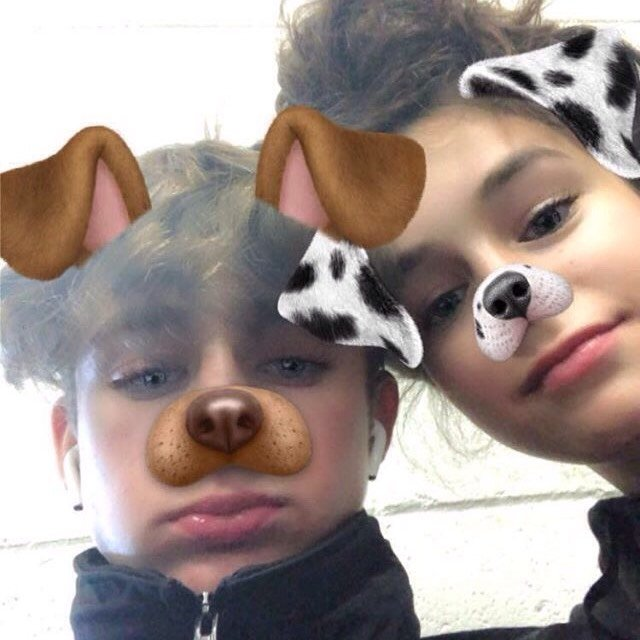

In [37]:
# and invalid profile picture with two faces

invalid_image = img_path + '/' + invalid_profile + '.jpg'

Image(invalid_image)

### 2.4 Data Preprocessing

// **this section should describe the bin-size splitting thing, section 3 will use that**

#### Instagram face detection

To filter the images that contain less or more than 1 face we run the following face detection algorithm.

In [35]:
from src.preprocess.face_detection.face_utils import getFaces
from os import walk

cut_image_path = './data/%s/images/%s/cut/' %(mode, country)
create_folder(cut_image_path)

for (dirpath, dirnames, filenames) in walk(img_path):
    for image in filenames:        
        username = image.split('.jpg')[0].split('/')
        name = username[len(username) - 1]        
        save_path = cut_image_path +'/%s.jpg' %name
        path = img_path + image
        print(path)
        faces = getFaces(path)
        if faces == 0:
            print('no face detected')
        elif len(faces) == 2:
            print('that is a couple')
        elif len(faces) == 1:
            print('there is one face') 
            cv.imwrite(save_path, faces[0])

./data/test/images/canada/@camybr_.jpg
there is one face
./data/test/images/canada/@mariiepierp21.jpg
there is one face
./data/test/images/canada/@maude_montpetit.jpg
there is one face
./data/test/images/canada/@coralie.sav.jpg
there is one face
./data/test/images/canada/@tiffounne.jpg
No face Detected, Checking next frame
no face detected
./data/test/images/canada/@audreyann.paquet.jpg
there is one face
./data/test/images/canada/@daphhh.hamel.jpg
No face Detected, Checking next frame
no face detected
./data/test/images/canada/@_frederiquem.jpg
that is a couple
./data/test/images/canada/@annesosimo.jpg
there is one face
./data/test/images/canada/@alyson_cote.jpg
there is one face
./data/test/images/canada/@1997kakou.jpg
there is one face
./data/test/images/canada/@lolobouu.jpg
that is a couple
./data/test/images/canada/@camybr_.jpg
there is one face
./data/test/images/canada/@mariiepierp21.jpg
there is one face
./data/test/images/canada/@maude_montpetit.jpg
there is one face
./data/tes

#### Instagram data labeling

Then, we label the received images according to the following convention:
<pre>
age_country_username.jpg
</pre>

and store the resulting images in one folder.

In [36]:
# Countries indexes mapping

countries = {
    "australia": "0",
    "brazil": "1",
    "canada": "2",
    "china": "3",
    "ethiopia": "4",
    "nigeria": "4",
    "germany": "5",
    "india": "6",
    "indonesia": "7",
    "iran": "8",
    "russia": "9"
}

data_path = './data/test/bio/filtered/%s.json' %country
result_path = './data/test/result'
create_folder(result_path)

with open(data_path, 'r') as file:
    user_profiles = json.load(file)
    for user in user_profiles:
        username = user['username']
        age = user['age']
        country_index = countries[country]
        
        image = cut_image_path + username + '.jpg'
        if os.path.exists(image):
        # The new name is 'age_country_username'
            new_name = '%s/%s_%s_%s.jpg' %(result_path, age, country_index, username)
            print(new_name)
            os.rename(image, new_name)

./data/test/result/21_2_@maude_montpetit.jpg
./data/test/result/20_2_@mariiepierp21.jpg
./data/test/result/23_2_@camybr_.jpg
./data/test/result/22_2_@1997kakou.jpg
./data/test/result/16_2_@annesosimo.jpg
./data/test/result/18_2_@alyson_cote.jpg
./data/test/result/19_2_@coralie.sav.jpg
./data/test/result/27_2_@audreyann.paquet.jpg


Finally, to split the pictures into bins that can be used as input to the model, it is necessary to run the following bash script in the _/result_ folder:

<pre> cd ./data/test/result
 bash bins_split.sh </pre>

## 3. Models and Training

In this section, we discuss the choosen models, the training configurations for each model, and the whole training pipeline. The outputs of this section are the saved trained weights for all models.

### 3.1 Model Selection

We targeted on 3 representative models in face recognition and age prediction, the MLP, VGG, and ResNet.

As there are many variants of these networks, the first thing is to determine which variants of these model are suitable for our project. 
We probed ResNet18, ResNet50, ResNet152 using parts of the training data (around 10,000) and found that the performance has no big difference. 
Thus we made the following selection:
- ResNet18, resnet with 18 layers
- VGG19_bn, vgg 19 layers with batch normalization
- MLP18, 18-layer mlp

The ResNet and VGG models can directly imported using the following statements:

In [ ]:
from torchvision.models import resnet18
from torchvision.models import vgg19_bn

And the MLP model is implemented by ourself and you can find it in the `./src/neural_network/mlp.py` in the [project github](https://github.com/occia/ce7454-group3-project).

For demo usage, here is a smaller version MLP implementation.

In [ ]:
# this class is for demo use
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, output_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            nn.Linear(hidden_size3, hidden_size4),
            nn.ReLU(),
            nn.Linear(hidden_size4, output_size)
        )
        
    def forward(self, x):
        # convert tensor (128, 1, 28, 28) --> (128, 1*28*28)
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x

### 3.2 Training Configuration

#### 3.2.1 Training Parameters Setup

We keep the following training configuration for all 3 choosen models:
- Learning Rate, the initial value of learning rate is set as `0.001`
- Optimizer, using **Adam** rather than **SGD**
- Criterion, using `torch.nn.CrossEntropyLoss()`
- Epoches, set to 50 as it balances the training time costs and the training consequence
- Batch size, set as 256
- Image pixels, set as `(3, 200, 200)`, 3 means 3 channels (a.k.a colors)

In [ ]:
#
# training parameters setup for demo use
#

device= torch.device("cuda")
#device= torch.device("cpu")

channels = 3
img_pixels = (200,200)
lr = 0.001
num_epochs = 2
batch_size = 128

# loading dataset
def loading_dataset(train_dataset, test_dataset):
    transform = transforms.Compose([
        transforms.Resize(img_pixels),
        transforms.ToTensor()])

    img_data_train = torchvision.datasets.ImageFolder(root=train_dataset, transform=transform)
    data_loader_train = torch.utils.data.DataLoader(img_data_train, batch_size=batch_size,shuffle=True)

    img_data_val = torchvision.datasets.ImageFolder(root=test_dataset, transform=transform)
    data_loader_val = torch.utils.data.DataLoader(img_data_val, batch_size=batch_size,shuffle=True)

    dataloaders = {}
    dataloaders['train'] = data_loader_train
    dataloaders['val'] = data_loader_val
    
    return dataloaders

#### 3.2.2 Model Training WorkFlow

The workflow is based on the template teacher provided in the class, and is improved in some aspects.

Here lists the code.

In [ ]:
#
# main training workflow
#
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()
    last = since
    time_elapsed = since

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            time_elapsed = time.time() - last
            last = time.time()
            
            print('{} Loss: {:.4f} Acc: {:.4f} Time: {:.0f}m {:.0f}s'.format(phase, epoch_loss, epoch_acc, time_elapsed // 60, time_elapsed % 60))

            # deep copy the modeltopk
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

The weights of the networks are initialized randomly.
Also the images of the dataset are shuffled every time.
The key different parts of our implementation from the teacher's template are:
- we do train & validation for every epoch
- based on the validation result, we save the best epoch's weights, and return that instead of the one be trained longest

### 3.3 Training Pipeline

Till now, we know which model to train and how to train a model. To answer the questions we raised at the beginning, we need to train all the combinations of the selected models and the prepared datasets.

Thus, the next step is building the training pipeline for all training combinations.

In [ ]:
# download demo dataset
#!wget -nc "https://somelink"
#!ls
#!tar xf ce7454_demo_dataset.tar.gz
#!ls dataset
#!mkdir -p ./saved_models

In [ ]:
def training_and_save_model(net, num_epochs, model_save_name):
    net = net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer=torch.optim.Adam(net.parameters(), lr)
    net, _ = train_model(net, dataloaders, criterion, optimizer, num_epochs)
    torch.save(net.state_dict(), os.path.join("./saved_models/", model_save_name))

#
# whole training pipeline
#
print("[+] This training pipeline is for demo usage")
for binsize in [1, 6, 10]:
    classes = int((100 + binsize - 1) / binsize)
    
    dataloaders = loading_dataset("./dataset/demo_train_bin_%d" % (binsize), "./dataset/demo_test_bin_%d" % (binsize))
    
    for model in ["MLP", "ResNet", "VGG"]:
        print("[+] Training for %s with binsize %d dataset started" % (model, binsize))
        
        if model == "MLP":
            net = MLP(channels * img_pixels[0] * img_pixels[1], 512, 512, 512, 512, classes)
        elif model == "ResNet":
            net = resnet18(num_classes=classes)
            # comment this as this is a demo
            #continue
        else:
            net = vgg19_bn(num_classes=classes)
            # comment this as this is a demo
            #continue
        
        model_save_name = "%s_%s_demo_merged_train_bin%d" % (num_epochs, net.__class__.__name__, binsize)
        training_and_save_model(net, num_epochs, model_save_name)

        print("[+] Training for %s with binsize %d dataset done" % (model, binsize))

        del net

As shown in the pipeline code, we saved weights of the best epoch for all the models towards all the datasets.

## 4. Evaluation

### 4.1 Accuracy Comparison Among Models

### 4.2 Accuracy in predicting age (age total/18 years)

### 4.3 Age perceived (age total/18 years x general/countries)
